In [1]:
import pandas as pd
import numpy as np
import chardet

try:
    # 1. Deteksi encoding file
    with open('ashrae_db.csv', 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
    
    encoding_detected = result['encoding']
    confidence = result['confidence']
    print(f"Encoding terdeteksi: {encoding_detected} (confidence: {confidence:.2f})")
    
    # Fallback ke utf-8 jika confidence rendah
    if confidence < 0.7:
        encoding_detected = 'utf-8'
        print(f"Menggunakan fallback encoding: {encoding_detected} karena confidence rendah")
    
    # 2. Baca file CSV
    data = pd.read_csv('ashrae_db.csv', 
                      encoding=encoding_detected, 
                      low_memory=False,
                      on_bad_lines='warn') 
    
    print("File berhasil dibaca dengan shape:", data.shape)

except FileNotFoundError:
    print("Error: File tidak ditemukan!")
except Exception as e:
    print(f"Error terjadi saat membaca file: {str(e)}")

Encoding terdeteksi: MacRoman (confidence: 0.73)
File berhasil dibaca dengan shape: (107583, 70)


In [2]:
print(data.columns)

Index(['Publication (Citation)', 'Data contributor', 'Year', 'Season',
       'Koppen climate classification', 'Climate', 'City', 'Country',
       'Building type', 'Cooling startegy_building level',
       'Cooling startegy_operation mode for MM buildings',
       'Heating strategy_building level', 'Age', 'Sex', 'Thermal sensation',
       'Thermal sensation acceptability', 'Thermal preference',
       'Air movement acceptability', 'Air movement preference',
       'Thermal comfort', 'PMV', 'PPD', 'SET', 'Clo', 'Met', 'activity_10',
       'activity_20', 'activity_30', 'activity_60', 'Air temperature (°C)',
       'Air temperature (°F)', 'Ta_h (°C)', 'Ta_h (°F)', 'Ta_m (°C)',
       'Ta_m (°F)', 'Ta_l (°C)', 'Ta_l (°F)', 'Operative temperature (°C)',
       'Operative temperature (°F)', 'Radiant temperature (°C)',
       'Radiant temperature (°F)', 'Globe temperature (°C)',
       'Globe temperature (°F)', 'Tg_h (°C)', 'Tg_h (°F)', 'Tg_m (°C)',
       'Tg_m (°F)', 'Tg_l (°C)', 'Tg_l (

In [3]:
print(data.describe())

                Year           Age  Thermal sensation  \
count  107335.000000  43579.000000      104454.000000   
mean     2002.010695     32.560173           0.167892   
std         8.821613     14.094305           1.241041   
min      1979.000000      6.000000          -3.000000   
25%      1995.000000     21.000000          -0.500000   
50%      1999.000000     29.000000           0.000000   
75%      2011.000000     43.000000           1.000000   
max      2016.000000     99.000000           3.000000   

       Thermal sensation acceptability  Air movement acceptability  \
count                     62444.000000                16347.000000   
mean                          0.775078                    0.785771   
std                           0.417534                    0.410299   
min                           0.000000                    0.000000   
25%                           1.000000                    1.000000   
50%                           1.000000                    1.000000

In [4]:
data = data.drop_duplicates()

In [5]:
data = data[
    ((data['Cooling startegy_building level'] == 'Air Conditioned') | 
     (data['Cooling startegy_building level'] == 'Mixed Mode'))
]

In [ ]:
import pandas as pd
import numpy as np

# Kolom yang relevan
selected_cols = [
    'Air temperature (°C)', 
    'Tg_h (°C)', 
    'Tg_m (°C)', 
    'Tg_l (°C)', 
    'Globe temperature (°C)', 
    'Operative temperature (°C)', 
    'Air velocity (m/s)'
]

# Fungsi untuk memilih Globe temperature atau fallback ke Tg_l, Tg_m, Tg_h
def pilih_globe_tg(row):
    if pd.notna(row['Globe temperature (°C)']):
        return row['Globe temperature (°C)']
    elif pd.notna(row['Tg_l (°C)']):
        return row['Tg_l (°C)']
    elif pd.notna(row['Tg_m (°C)']):
        return row['Tg_m (°C)']
    elif pd.notna(row['Tg_h (°C)']):
        return row['Tg_h (°C)']
    else:
        return np.nan

# Fungsi untuk menghitung MRT dari Globe Temperature
def hitung_mrt_dari_globe(row):
    Tg_value = pilih_globe_tg(row)
    if pd.notna(Tg_value):
        Ta = row['Air temperature (°C)']
        V = max(row['Air velocity (m/s)'], 0.1)  
        D = 0.15  # Diameter globe (m)
        epsilon = 0.95  # Emisivitas
        
        mrt = (
            (Tg_value + 273.15)**4 + 
            (1.1 * 10**8 * V**0.6) / (epsilon * D**0.4) * (Tg_value - Ta))**0.25 - 273.15
        return mrt
    else:
        return np.nan

# Fungsi untuk menghitung MRT dari Operative Temperature
def hitung_mrt_dari_operative(row):
    To = row['Operative temperature (°C)']
    Ta = row['Air temperature (°C)']
    if pd.notna(To) and pd.notna(Ta):
        return 2 * To - Ta  
    else:
        return np.nan

# Hitung MRT dengan kedua metode
data['MRT dari Globe (°C)'] = data.apply(hitung_mrt_dari_globe, axis=1)
data['MRT dari Operative (°C)'] = data.apply(hitung_mrt_dari_operative, axis=1)

# Simpan hasil akhir ke kolom "Radiant temperature (°C)"
data['Radiant temperature (°C)'] = data['MRT dari Globe (°C)'].combine_first(data['MRT dari Operative (°C)']).round(2)

# Hapus kolom sementara jika tidak diperlukan
data.drop(['MRT dari Globe (°C)', 'MRT dari Operative (°C)'], axis=1, inplace=True)

# Tampilkan hasil
print("Hasil Perhitungan Radiant Temperature:")
print(data[[
    'Air temperature (°C)', 
    'Globe temperature (°C)', 
    'Tg_l (°C)', 
    'Tg_m (°C)', 
    'Tg_h (°C)', 
    'Operative temperature (°C)', 
    'Air velocity (m/s)', 
    'Radiant temperature (°C)'
]])


Hasil Perhitungan Radiant Temperature:
        Air temperature (°C)  Globe temperature (°C)  Tg_l (°C)  Tg_m (°C)  \
0                       24.2                    24.0        NaN        NaN   
1                       24.2                    24.0        NaN        NaN   
2                       24.2                    24.0        NaN        NaN   
3                       24.2                    24.0        NaN        NaN   
4                       24.2                    24.0        NaN        NaN   
...                      ...                     ...        ...        ...   
107578                   NaN                    22.1        NaN        NaN   
107579                   NaN                    22.1        NaN        NaN   
107580                   NaN                    22.1        NaN        NaN   
107581                   NaN                    22.1        NaN        NaN   
107582                   NaN                    22.1        NaN        NaN   

        Tg_h (°C)  Opera

In [7]:
# Kolom yang dipilih
selected_cols = ['Air temperature (°C)',
                'Relative humidity (%)',
                'Radiant temperature (°C)', 
                'Air velocity (m/s)',
                'Clo',
                'Met',
                'PMV']

# Hitung jumlah NaN dan 0 per kolom
missing_stats = pd.DataFrame({
    'Kolom': selected_cols,
    'Jumlah NaN': data[selected_cols].isna().sum().values,
    'Jumlah 0': (data[selected_cols] == 0).sum().values,
    'Total Missing (NaN + 0)': (data[selected_cols].isna() | (data[selected_cols] == 0)).sum().values
})

print("=" * 50)
print("JUMLAH DATA MISSING (NaN ATAU 0)")
print("=" * 50)
print(missing_stats.to_string(index=False))  
print("=" * 50)

JUMLAH DATA MISSING (NaN ATAU 0)
                   Kolom  Jumlah NaN  Jumlah 0  Total Missing (NaN + 0)
    Air temperature (°C)        2525         0                     2525
   Relative humidity (%)        2117         0                     2117
Radiant temperature (°C)       14939         0                    14939
      Air velocity (m/s)        6434       989                     7423
                     Clo        3276        10                     3286
                     Met        8054         0                     8054
                     PMV       19333      1718                    21051


Skewness Tiap Kolom:
Air temperature (°C)      0.990279
Relative humidity (%)     0.154588
Air velocity (m/s)       86.169340
dtype: float64
Imputasi kolom Air temperature (°C) dengan median: 23.8
Imputasi kolom Relative humidity (%) dengan mean: 46.42
Imputasi kolom Air velocity (m/s) dengan median: 0.09


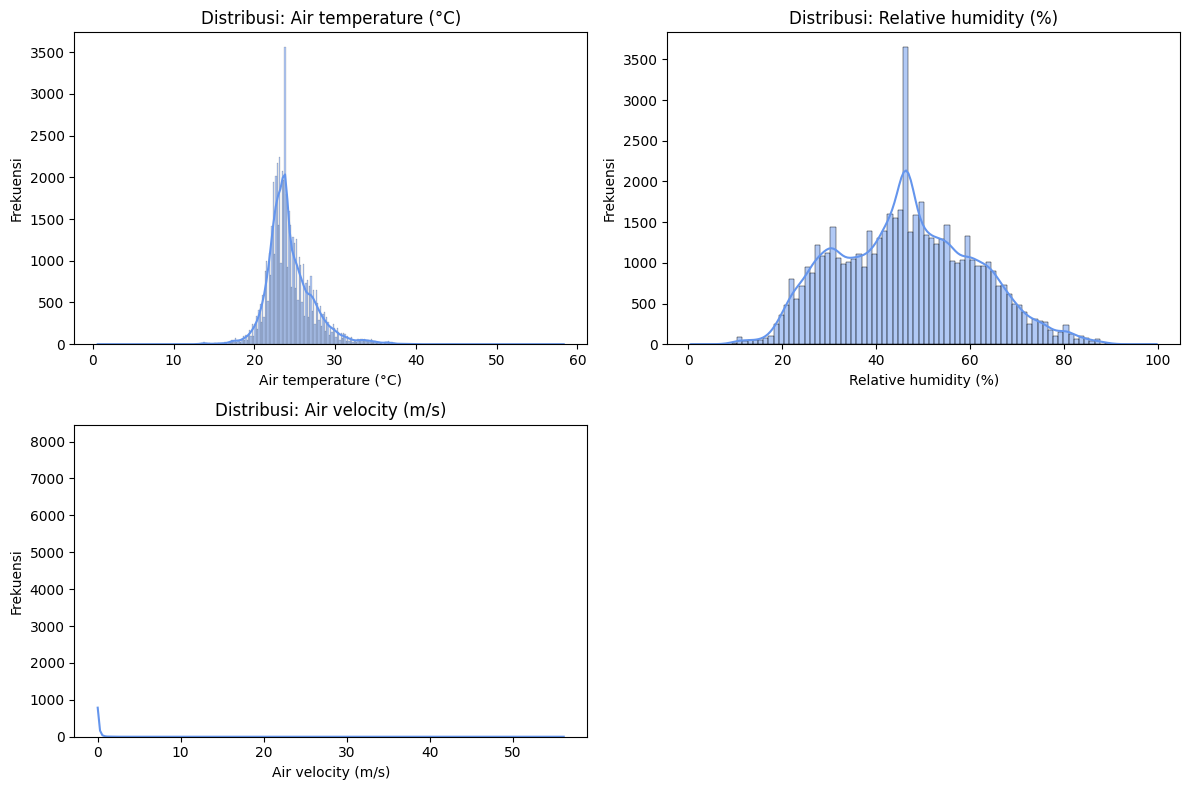

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih kolom lingkungan yang akan diproses
selected_cols = ['Air temperature (°C)', 
                 'Relative humidity (%)', 
                 'Air velocity (m/s)']

# Hitung skewness
skewness = data[selected_cols].skew()
print("Skewness Tiap Kolom:")
print(skewness)

# Imputasi berdasarkan skewness 
for col in selected_cols:
    if skewness[col] > 0.5: 
        impute_value = round(data[col].median(), 2)
        method = 'median'
    else:  
        impute_value = round(data[col].mean(), 2)
        method = 'mean'
    print(f"Imputasi kolom {col} dengan {method}: {impute_value}")
    data[col] = data[col].fillna(impute_value)

# Visualisasi distribusi setelah imputasi
plt.figure(figsize=(12, 8))
for i, col in enumerate(selected_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[col], kde=True, color='cornflowerblue')
    plt.title(f'Distribusi: {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


In [9]:
# Hapus baris yang nilai Radiant temperature (°C) adalah NaN
before = len(data)
data = data.dropna(subset=['Radiant temperature (°C)'])
after = len(data)

print(f"Jumlah baris sebelum dihapus: {before}")
print(f"Jumlah baris setelah dihapus: {after}")
print(f"Jumlah baris yang dihapus: {before - after}")


Jumlah baris sebelum dihapus: 56446
Jumlah baris setelah dihapus: 41507
Jumlah baris yang dihapus: 14939


In [10]:
from pythermalcomfort.models import pmv_ppd_ashrae
import numpy as np
import pandas as pd
import warnings

# Abaikan warning sebelum apa pun dilakukan
warnings.filterwarnings("ignore", category=UserWarning)

# Pastikan nama kolom tidak ada spasi ekstra
data.columns = data.columns.str.strip()

# 1. Set semua nilai PMV menjadi NaN terlebih dahulu
data['PMV'] = np.nan  

# 2. Fungsi untuk menghitung PMV dengan error handling
def calculate_pmv(row):
    try:
        # Pastikan semua input numerik dan dalam range valid
        tdb = float(row['Air temperature (°C)'])
        tr = float(row['Radiant temperature (°C)'])
        vr = float(row['Air velocity (m/s)'])
        rh = float(row['Relative humidity (%)'])

        # Validasi range input (sesuaikan jika perlu)
        if not (10 <= tdb <= 50) or not (10 <= tr <= 50):
            print(f"Warning: Suhu di luar range normal (10-50°C): Ta={tdb}, Tr={tr}")
            return np.nan
        if not (0 <= vr <= 10):
            print(f"Warning: Kecepatan udara di luar range normal (0-10 m/s): VR={vr}")
            return np.nan
        if not (0 <= rh <= 100):
            print(f"Warning: Kelembaban di luar range (0-100%): RH={rh}")
            return np.nan

        # Hitung PMV
        result = pmv_ppd_ashrae(
            tdb=tdb,
            tr=tr,
            vr=vr,
            rh=rh,
            met=1.2,  
            clo=0.5,  
        )

        return round(result['pmv'], 2)  

    except Exception as e:
        print(f"Error saat menghitung PMV: {e}")
        return np.nan

# 3. Hitung ulang PMV untuk semua baris
data['PMV'] = data.apply(calculate_pmv, axis=1)

# 4. Cek hasil
print("Statistik PMV setelah perhitungan ulang:")
print(data['PMV'].describe())
print("\nJumlah nilai NaN:", data['PMV'].isna().sum())


Statistik PMV setelah perhitungan ulang:
count    41355.000000
mean        -0.241495
std          0.814502
min         -4.850000
25%         -0.740000
50%         -0.350000
75%          0.200000
max          4.470000
Name: PMV, dtype: float64

Jumlah nilai NaN: 152


In [11]:
# Assuming reasonable ranges for temperature, humidity, air flow, and MRT
data = data[(data['Air temperature (°C)'] >= 10) & (data['Air temperature (°C)'] <= 50)]  
data = data[(data['Relative humidity (%)'] >= 0) & (data['Relative humidity (%)'] <= 100)]        
data = data[(data['Air velocity (m/s)'] > 0) & (data['Air velocity (m/s)'] <= 10)]           
data = data[(data['Radiant temperature (°C)'] >= 10) & (data['Radiant temperature (°C)'] <= 50)]                   
data = data[(data['PMV'] >= -3) & (data['PMV'] <= 3)]          

data.head()

,Publication (Citation),Data contributor,Year,Season,Koppen climate classification,Climate,City,Country,Building type,Cooling startegy_building level,...,Subject´s height (cm),Subject´s weight (kg),Blind (curtain),Fan,Window,Door,Heater,Outdoor monthly air temperature (°C),Outdoor monthly air temperature (°F),Database
0,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,162.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
1,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,154.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
2,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,173.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
3,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,167.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
4,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,178.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2


In [12]:
# Pilih Kolom Relevan
selected_columns = [
        'Air temperature (°C)', 'Relative humidity (%)', 
        'Air velocity (m/s)', 'Radiant temperature (°C)', 
        'PMV'
    ]
data = data[selected_columns].rename(columns={
        'Air temperature (°C)': 'temperature',
        'Relative humidity (%)': 'humidity',
        'Air velocity (m/s)': 'air_flow',
        'Radiant temperature (°C)': 'mrt',
        'PMV': 'pmv'
    })

data.head()

,temperature,humidity,air_flow,mrt,pmv
0,24.2,50.2,0.06,23.88,-0.17
1,24.2,50.2,0.06,23.88,-0.17
2,24.2,50.2,0.06,23.88,-0.17
3,24.2,50.2,0.06,23.88,-0.17
4,24.2,50.2,0.06,23.88,-0.17


In [13]:
print(data.describe())

        temperature      humidity     air_flow           mrt           pmv
count  40342.000000  40342.000000  40342.00000  40342.000000  40342.000000
mean      24.291277     44.715745      0.12133     24.399275     -0.238453
std        2.840432     13.417914      0.16689      3.098268      0.789089
min       10.800000      6.400000      0.01000     10.460000     -3.000000
25%       22.500000     34.300000      0.04000     22.580000     -0.740000
50%       23.700000     44.800000      0.08000     23.990000     -0.350000
75%       25.600000     54.400000      0.13000     25.800000      0.200000
max       38.900000     89.000000      2.00000     39.990000      3.000000


In [14]:
print(data.shape)

(40342, 5)


In [15]:
data.to_csv('cleaned_data_pmv.csv', index=False)
print("\nData yang sudah dibersihkan dari outlier disimpan sebagai 'cleaned_data_pmv.csv'.")


Data yang sudah dibersihkan dari outlier disimpan sebagai 'cleaned_data_pmv.csv'.


In [16]:
# Cek jumlah NaN dan 0
print("Jumlah NaN:\n", data.isna().sum())
print("\nJumlah 0:\n", (data == 0).sum())

Jumlah NaN:
 temperature    0
humidity       0
air_flow       0
mrt            0
pmv            0
dtype: int64

Jumlah 0:
 temperature      0
humidity         0
air_flow         0
mrt              0
pmv            167
dtype: int64


MATRIX KORELASI (PEARSON)
             temperature  humidity  air_flow   mrt   pmv
temperature         1.00      0.15      0.42  0.88  0.93
humidity            0.15      1.00      0.15  0.19  0.26
air_flow            0.42      0.15      1.00  0.43  0.19
mrt                 0.88      0.19      0.43  1.00  0.91
pmv                 0.93      0.26      0.19  0.91  1.00


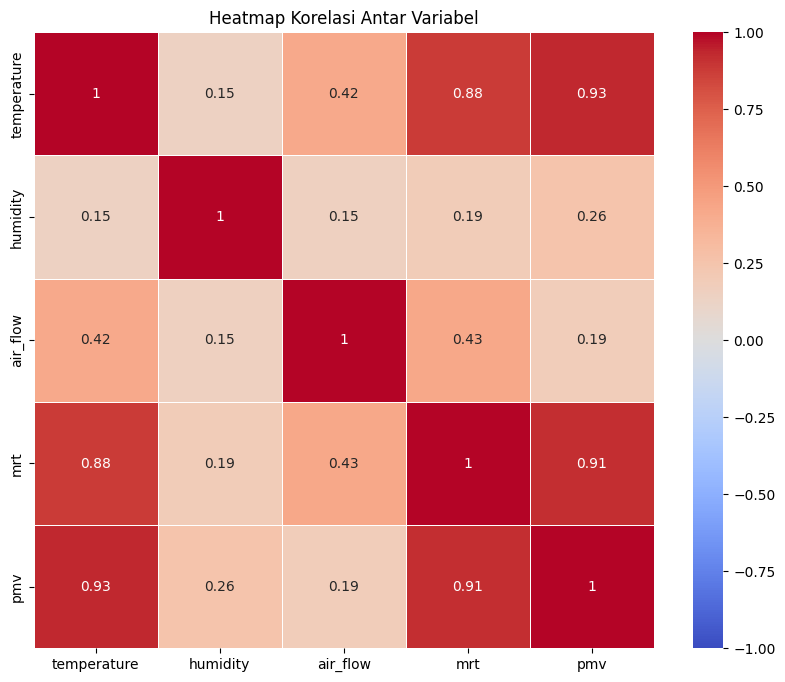


Korelasi PMV dengan Variabel Lain:
pmv            1.000000
temperature    0.930756
mrt            0.914129
humidity       0.256255
air_flow       0.186541
Name: pmv, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Baca dataset yang sudah dibersihkan
data = pd.read_csv('cleaned_data_pmv.csv')

# 1. Hitung Matrix Korelasi (Pearson)
correlation_matrix = data.corr(numeric_only=True)

# 2. Tampilkan Korelasi dalam Tabel
print("=" * 50)
print("MATRIX KORELASI (PEARSON)")
print("=" * 50)
print(correlation_matrix.round(2)) 

# 3. Visualisasi Heatmap Korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    linewidths=0.5
)
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

# 4. Korelasi PMV dengan Variabel Lain
print("\nKorelasi PMV dengan Variabel Lain:")
print(correlation_matrix['pmv'].sort_values(ascending=False))

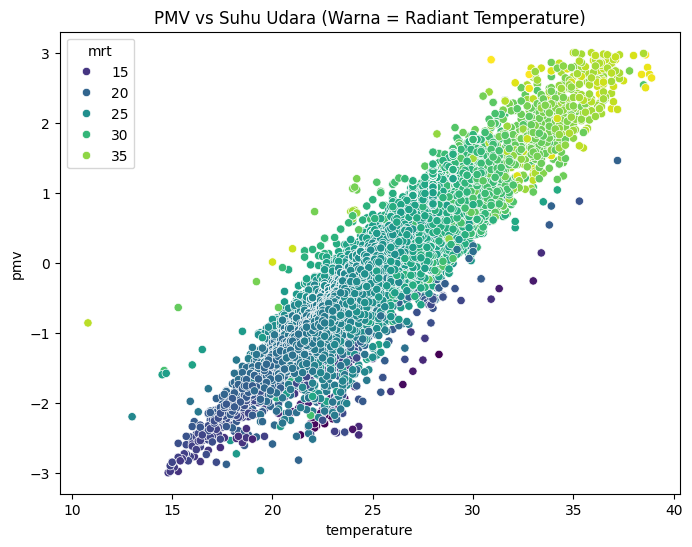

In [18]:
# Scatter plot untuk hubungan temperature vs PMV
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='temperature', y='pmv', hue='mrt', palette='viridis')
plt.title("PMV vs Suhu Udara (Warna = Radiant Temperature)")
plt.show()

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ambil fitur independen (jangan termasuk variabel target)
X = data[['temperature', 'humidity', 'air_flow', 'mrt']]

# Tambahkan kolom konstanta untuk intercept
X = sm.add_constant(X)

# Hitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


       Feature        VIF
0        const  90.784789
1  temperature   4.340143
2     humidity   1.048125
3     air_flow   1.244310
4          mrt   4.443392
